# Logistic Regression with Tfidf Vectorization & ngrams_range = (1,2)

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.functions import col, split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import json

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import pickle

In [2]:
 def report(fitted):   
    ypred = fitted.predict(Xtest)

    print("[Training Classification Report:]")
    print(classification_report(ytrain, fitted.predict(Xtrain)))
    print('Training Accuracy: ',accuracy_score(fitted.predict(Xtrain), ytrain))
    print('')
    print("[Test Classification Report:]")
    print(classification_report(ytest, ypred))
    print('Test Accuracy: ', accuracy_score(ypred, ytest))

    yprobs = fitted.predict_proba(Xtest)[:,1]
    fpr, tpr, threshold = roc_curve(ytest,  yprobs)
    roc_auc = auc(fpr, tpr)
    print('')
    print('AUC: ', roc_auc)
    print('')
    print('Log loss: ', log_loss(ytest, yprobs))
    
    return ypred, yprobs
    
def make_x(REVtrain, REVtest, vectorizer=None, min_df = 1, max_df = 1.0):
    """Create the matrix of features """
    if vectorizer is None:
        print('The value of vectorizer is None ... using CountVectorizer')
    else:
        print('The value of vectorizer is NOT None ... using the provided vectorizer')
    #
    if vectorizer is None:
        vectorizer = CountVectorizer(strip_accents = 'ascii', stop_words = sw, 
                                     min_df = min_df, max_df = max_df)
   
    Xtrain = vectorizer.fit_transform(REVtrain)
    Xtrain = Xtrain.tocsc() 
    
    Xtest = vectorizer.transform(REVtest)
    Xtest = Xtest.tocsc()
    
    return Xtrain, Xtest, vectorizer 

In [3]:
infile = open('../SavedFiles/fastFood_eng_binary.pkl', 'rb')
fastFood = pickle.load(infile)
infile.close

<function BufferedReader.close>

In [4]:
sw = set(stopwords.words('english'))
sw

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [5]:
#don't want to remove all the stopwords - for example "not good" is very different than "good", but not is
#   a stopword.  I will just remove a few stop words and some punctuation
sw = ['a', 'an', 'the', 'and']

In [6]:
sw = sw + ['.', ',', '...', '\'\'', '\"', '``', '¡',  '{','|','||','}', '(', ')', 
                '\'','[',']', ';', ':', '-', '_','—', '\\','/', '*', '~', '?', '!']

## Make X and y 

In [7]:
tfidf = TfidfVectorizer(strip_accents = 'ascii', stop_words = sw, ngram_range = (1,2), max_df = 0.7)

In [8]:
REVtrain, REVtest, ytrain, ytest = train_test_split(fastFood.text_tok, fastFood.pos, random_state = 123)

In [9]:
REVtest.shape

(54916,)

In [10]:
Xtrain, Xtest, vectorizer = make_x(REVtrain, REVtest, vectorizer = tfidf)

The value of vectorizer is NOT None ... using the provided vectorizer


In [11]:
n_rows, n_cols = Xtrain.shape
print('Number of reviews: ', n_rows)
print('Number of terms: ', n_cols)

Number of reviews:  164748
Number of terms:  1903022


In [12]:
feature_names = vectorizer.get_feature_names()

In [13]:
word_frequencies = np.array([Xtrain[:,i].count_nonzero() for i in range(n_cols)])

In [14]:
max_doc_freq = np.max(word_frequencies)
x_values = range(max_doc_freq)
x_values

range(0, 101109)

In [15]:
#what unigram or bigram appears in the most reviews? 
most_freq_idx = list(word_frequencies).index(max_doc_freq)
feature_names[most_freq_idx]

'it'

## Hyperparameter Tuning

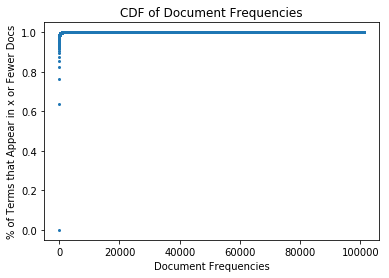

In [16]:
y_values  = np.array([np.sum(word_frequencies <= i) for i in x_values])/n_cols

plt.plot(x_values,y_values, marker = 'o',markersize = 2, linestyle = 'none')

plt.xlabel('Document Frequencies')
plt.ylabel('% of Terms that Appear in x or Fewer Docs')
plt.title('CDF of Document Frequencies')
plt.savefig('../SavedFiles/CDFofDocFreq_ngram12')

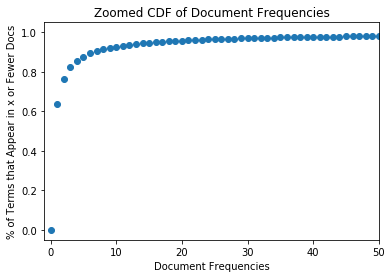

In [17]:
plt.plot(x_values,y_values, marker = 'o',linestyle = 'none')
plt.xlim([-1,50])
plt.xlabel('Document Frequencies')
plt.ylabel('% of Terms that Appear in x or Fewer Docs')
plt.title('Zoomed CDF of Document Frequencies')
plt.savefig('../SavedFiles/ZoomedCDFofDocFreq_ngram12')

Text(0.5, 1.0, 'Zoomed CDF of Document Frequencies')

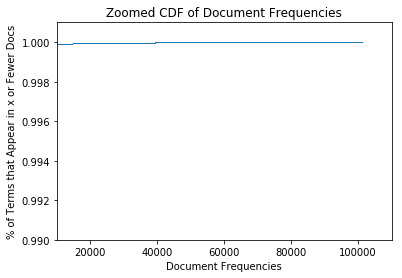

In [18]:
plt.plot(x_values,y_values, marker = '.', markersize = 0.02,linestyle = 'none')
plt.xlim(10000,110000)
plt.ylim(0.99,1.001)
plt.xlabel('Document Frequencies')
plt.ylabel('% of Terms that Appear in x or Fewer Docs')
plt.title('Zoomed CDF of Document Frequencies')

In [19]:
#choosing min_df = 3, max_df = 70000 --> overfitting - training accuracy 0.984, test accuracy = 0.896
# 0.9032 with certain stopwords
#min_df = 6, max_df = 50000, training accuracy 0.9065 overfitting
tfidf = TfidfVectorizer(strip_accents = 'ascii', stop_words = sw, ngram_range = (1,2), min_df = 35, max_df = 45000)

In [20]:
Xtrain, Xtest, vectorizer = make_x(REVtrain, REVtest, vectorizer = tfidf)

The value of vectorizer is NOT None ... using the provided vectorizer


In [21]:
n_rows, n_cols = Xtrain.shape
print('Number of reviews: ', n_rows)
print('Number of terms: ', n_cols)

Number of reviews:  164748
Number of terms:  51515


In [22]:
feature_names = vectorizer.get_feature_names()
word_frequencies = np.array([Xtrain[:,i].count_nonzero() for i in range(n_cols)])
max_doc_freq = np.max(word_frequencies)
max_doc_freq

44789

In [23]:
most_freq_idx = list(word_frequencies).index(max_doc_freq)
feature_names[most_freq_idx]

'service'

## Logistic Regression - min_df = 35, max_df = 45000

In [24]:
#Cross VALIDATION
param_grid = {'C': [0.001, 0.1, 1, 10, 100]}
logistic = LogisticRegression(solver = 'lbfgs')
logreg_cv = GridSearchCV(logistic, param_grid, cv = 5)
fitted = logreg_cv.fit(Xtrain, ytrain)
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs 

Tuned Logistic Regression Parameters: {'C': 1}
Best score is 0.9037742491562871


/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [25]:
ypred, yprobs = report(fitted)

[Training Classification Report:]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     82065
           1       0.92      0.93      0.93     82683

   micro avg       0.93      0.93      0.93    164748
   macro avg       0.93      0.93      0.93    164748
weighted avg       0.93      0.93      0.93    164748

Training Accuracy:  0.9269611770704348

[Test Classification Report:]
              precision    recall  f1-score   support

           0       0.91      0.90      0.91     27281
           1       0.91      0.91      0.91     27635

   micro avg       0.91      0.91      0.91     54916
   macro avg       0.91      0.91      0.91     54916
weighted avg       0.91      0.91      0.91     54916

Test Accuracy:  0.906784907859276

AUC:  0.9664413624942066

Log loss:  0.24192484745324933


In [26]:
confusion_matrix(ytest, ypred)

array([[24686,  2595],
       [ 2524, 25111]])

## Save Results

In [27]:
results = pd.DataFrame(REVtest)
results.head()

,text_tok
172202,my wife and i picked up dinner at el pollo loc...
57202,visited the restaurant recently and was quite ...
31914,worst experience ever not the first time but m...
1441,blaze pizza is easily one of my favorite place...
184107,people made this place seem like the best plac...


In [28]:
results['ypred'] = ypred

In [29]:
results['prob_pos'] = yprobs

In [30]:
results.head()

,text_tok,ypred,prob_pos
172202,my wife and i picked up dinner at el pollo loc...,0,0.489961
57202,visited the restaurant recently and was quite ...,0,0.022665
31914,worst experience ever not the first time but m...,0,0.029074
1441,blaze pizza is easily one of my favorite place...,1,0.994461
184107,people made this place seem like the best plac...,0,0.007200


In [31]:
LRtfidf_results = fastFood.drop(REVtrain.index)

In [32]:
LRtfidf_results = pd.concat([LRtfidf_results, results], axis = 1, join = 'outer')

In [33]:
LRtfidf_results.shape

(54916, 17)

In [34]:
LRtfidf_results = LRtfidf_results[['review_id','business_id','name','text','stars','pos', 'ypred', 'prob_pos']]

In [35]:
LRtfidf_results.head()

,review_id,business_id,name,text,stars,pos,ypred,prob_pos
14,-IISbnbz_R1X21uOXHD39g,_HGz-BfLYJlShdz_eg3BOw,Windy City Dogs,Good for kids.\n\n Windy City Dogs features V...,2.0,0,1,0.615870
22,WPe_6jngcTeC5keB5WxPCw,Zx4CreRji7Dxgl8iqa1DXw,Raising Cane's Chicken Fingers,Delicious chicken! Love the dipping sauce. R...,5.0,1,1,0.987081
23,Q3gHMQZCT5Vs9r58xVqsTQ,lYv2-FaGQBhZnVxTb3Qc5Q,Wendy's,I have been here a few times but today the foo...,4.0,1,1,0.950613
24,AaDC5rIWkqUjYwHO6aiSKA,YeYtDdGRonHddnviDc1q7g,Teriyaki Boy Healthy Grill,Delicious and healthy! I love that they are n...,4.0,1,1,0.985481
25,dLOylrREncIKdMpLulFgpA,6rN_wreWNCl3wLNZYZCYOA,Applebee's Grill + Bar,The good was TERRIBLE! In addition to that the...,1.0,0,0,0.005842


In [37]:
outfile = open('../SavedFiles/LRtfidf_results.pkl', 'wb')
pickle.dump(LRtfidf_results, outfile)
outfile.close()